# Lab 3: Stochastic Gradient Descent


The goal of this lab session is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

You have to send the filled notebook named **"L3_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 17, 2019. Please put **"AML-L3"** in the subject. 

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [2]:
from sklearn import model_selection

diabetes_data = pd.read_csv("lab3_data.csv", sep=",")

diabetes_train, diabetes_test = model_selection.train_test_split(diabetes_data)
diabetes_train_x = diabetes_train.iloc[:, :-1].values
diabetes_train_y = diabetes_train.iloc[:, -1].values
diabetes_train_y[diabetes_train_y == 0] = -1

diabetes_test_x = diabetes_test.iloc[:, :-1].values
diabetes_test_y = diabetes_test.iloc[:, -1].values
diabetes_test_y[diabetes_test_y == 0] = -1

## Logistic Regression



Today we’ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [3]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=2) 
model.fit(diabetes_train_x, diabetes_train_y)
y_pred = model.predict(diabetes_test_x)

and we compute the accuracy score to evaluate the model performance:

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(diabetes_test_y, y_pred)

0.8072916666666666

### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

Considering the following loss : $$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$
    The coordinates of its gradient can be written : $$\forall j \in \{1,...p\} \ \frac {\partial L(\textbf{w})}{\partial \textbf{w}_j} = \sum_{i=1}^n \frac{-y_i x_{i,j}}{1+\exp(-y_i\textbf{w}^Tx_i))}\exp(-y_i\textbf{w}^Tx_i))+ \lambda\textbf{w}_j ,$$ 
    
where $p$ is the number of features of $x$ and $n$ the number of observations.
    
We can use the following matrix formulation :
$$\forall j \in \{1,...p\} \ \nabla L(\textbf{w}) = \sum_{i=1}^n A_i^T $$ where $A_i$ is the i-th ligne of $$A \in \mathcal {M}_{n,p}, \ A = -Y * x * F(- \textbf{y} * x \textbf{w})+ \frac{\lambda}{n} W ,$$ in which : 
* $Y$ is the $\textbf{y}$ column vector repeated $p$ times,
* $W$ is the $\textbf{w}^T$ line vector repeated $n$ times (this cause the $\lambda$ factor to be divided by $n$ to keep the same effect),
* $*$ is the elementwise multiplication between two matrixes or vectors and,
* $F(\textbf{u})$ is obtained by applying the logistic function $f$  to each coordinate of $\textbf{u}$ a vector of size $n$ and repeating the resulting column vector $p$ times. 
            
In the implementation we will consider a mean over $A_i$ rather than a sum to be independant regarding the number of terms in the sum (batch size).

# Implementation 
The following implementation will be used to answer the several questions of the lab with different parameters. 

In [15]:
class StochasticLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    """
    def __init__(self, alpha, lr_method = {'method':'constant'}, seed=0):
        self.seed_ = seed
        self.coef_  = None
        self.alpha_ = alpha
        self.lr_     = None
        self.bsize_  = None
        self.coef_history_ = []
        self.f_history_ = []
        self.acc_history = []
        self.lr = None
        self.lr_method = lr_method
    def logistic(self, z):
        """ Compute the logistic function's output for an input z.

        Parameters:
        -----------
        z: number or array, argument for the logistic function, it will eventually be broadcasted   
        """       
        return( 1 / (1 + np.exp(-z)))
 
        
    def fit(self, X, y, start=None, lr=1e-3, batch_size=50, max_iter=500, averaging=False, tolerance=1e-4, acceleration=None):
        """ Fit the data (X, y).

        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        """       
        momentum = (acceleration == 'momentum') * 0.5
        gradient_averaging = acceleration == 'gradient_averaging'
        adagrad = acceleration == 'adagrad'
        self.lr = lr # we use an attribute for the learning for decay or adaptive strategy
        
        y = y.reshape(y.shape[0],1) # adding the feature dimension to avoid broadcasting errors
        np.random.seed(self.seed_)
        self.coef_ = np.random.random((1, X.shape[1]+1)) # we add one to the p dimension to add bias
                                                        # we use a second axis for the features to be consistent
                                                        # when using broadcasting
        extended_X = np.pad(X, ((0, 0), (0,1)), 'constant', constant_values = 1) 
        def f_lr( beta):
            '''evaluate the F=\sum_{i=1}^n f_i in beta'''
            a = np.sum(np.log((1 + np.exp(  - y * (extended_X @ self.coef_.T))))) # using a similar
                                                               #broadcasting as for the gradient
            
            b = self.alpha_ * np.dot(self.coef_, self.coef_.T) / 2 # adding penalization
            return(a + b)
               
        self.coef_history_.append(self.coef_) # storing the initialized coefficients
        epoch = 0
        # we consider the number of iteration 
        converged = False
        grad = np.zeros(self.coef_.shape)
        indexes = np.arange(y.shape[0])
        if momentum : 
            prev_coef = self.coef_
        if adagrad: 
            sum_gt = 0
        while epoch < max_iter and not converged:
            epoch += 1
            lr = self.get_lr(epoch)
            np.random.shuffle(indexes)
            for i in range(y.shape[0] // batch_size):
                # we select the element of the dataset to make a batch
                b_indexes = indexes[i * batch_size:(i + 1) * batch_size]
                y_batch = y[indexes]
                x_batch = extended_X[indexes]
                
                #we compute the gradient according to the formula above (we use the transpose 
                #for the vectors along the feature dimension to avoid broadcasting errors)
                #for the same reason we keep the dimensions after the mean 
                # note : for the matricial product we use the transpose of the coef because it 
                #has been instanciatd as a line vector an not a column
                grad_ = (-self.logistic(-(y_batch * (x_batch @ self.coef_.T))) *
                        y_batch * x_batch +
                        self.alpha_ * self.coef_) # the regularizing factor will be divided by 1/n by the mean
                
                
                if gradient_averaging : 
                    grad = (1/epoch) * np.mean(grad_, axis = 0, keepdims=True)  + (1-1/epoch) * grad
                    
                else: 
                    grad = np.mean(grad_,axis = 0,keepdims=True)
                    
                
                
                if averaging:
                    self.coef_ = (1-1/epoch)*self.coef_ + 1/epoch * (self.coef_ - lr * grad)
                
                elif momentum: 
                    self.coef_ -= lr * (1-momentum) * grad - momentum * (self.coef_ - prev_coef)
                elif adagrad: 
                    sum_gt +=  np.diag(self.coef_.T * self.coef_).reshape(grad.shape)
                    self.coef_ -= lr * grad / np.sqrt(sum_gt + 1e-10)
                else:
                    self.coef_ -= lr * grad
                
                if tolerance > np.sum(np.abs(grad)):
                    converged = True
            self.coef_history_.append(np.squeeze(self.coef_)) # we squeeze to remove the unnecessary
                                                                # dimension for scoring
            self.f_history_.append(np.squeeze(f_lr(self.coef_)))
            self.acc_history.append(np.mean(self.predict(X)==np.squeeze(y)))
            
            
            
    def get_lr(self, i): 
        if self.lr_method['method'] == 'constant': 
            return self.lr
        if self.lr_method['method'] == 'inv_decay': 
            return self.lr/(i**self.lr_method['nu'])
            

    
    def predict(self, X):
        """ Make binary predictions for data X.

        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix

        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """
        extended_X = np.pad(X, ((0, 0), (0,1)), 'constant', constant_values = 1) 
        return np.squeeze(np.round(self.logistic(np.matmul(extended_X, self.coef_.T))) * 2 - 1) # we similar broadcasted expression

## Gradient Descent
The gradient descent correspond to a stochastic gradient descent but with all the dataset in each batch. 


Performance for seed 0 : train acc = 0.678261 | test acc = 0.645833 | last loss 362.931144
Performance for seed 1 : train acc = 0.697391 | test acc = 0.692708 | last loss 352.082039
Performance for seed 2 : train acc = 0.693913 | test acc = 0.692708 | last loss 350.013784


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp


Performance for seed 3 : train acc = 0.704348 | test acc = 0.697917 | last loss 350.637069
Performance for seed 0 : train acc = 0.683478 | test acc = 0.661458 | last loss 360.031017
Performance for seed 1 : train acc = 0.695652 | test acc = 0.687500 | last loss 350.944879
Performance for seed 2 : train acc = 0.695652 | test acc = 0.687500 | last loss 349.143625
Performance for seed 3 : train acc = 0.700870 | test acc = 0.703125 | last loss 348.640679


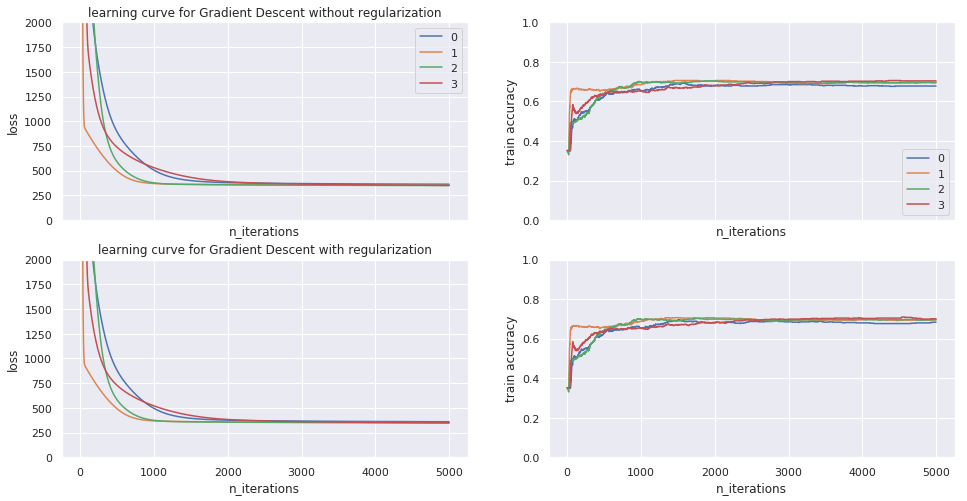

In [6]:
n_seeds = 4
lr = 2.5e-4
max_iter = 5000
fg , axes = plt.subplots(2,2, figsize=(16, 8), sharex='all')
axes.flatten()[0].set_ylabel('loss')
axes.flatten()[0].set_ylim(0,2000)
axes.flatten()[1].set_ylim(0,1)
axes.flatten()[1].set_ylabel('train accuracy')
axes.flatten()[0].set_xlabel('n_iterations')
axes.flatten()[1].set_xlabel('n_iterations')
axes.flatten()[0].set_title('learning curve for Gradient Descent without regularization')
for seed in range(n_seeds):
    logistic_regression = StochasticLogisticRegression(0,seed=seed)
    logistic_regression.fit(diabetes_train_x, diabetes_train_y, lr=lr, batch_size=len(diabetes_train), max_iter=max_iter)
    axes.flatten()[0].plot(logistic_regression.f_history_, label='no averaging')
    axes.flatten()[1].plot(logistic_regression.acc_history, label='no averaging')
    train_acc =  np.mean(logistic_regression.predict(diabetes_train_x) == diabetes_train_y)
    test_acc = np.mean(logistic_regression.predict(diabetes_test_x) == diabetes_test_y)
    print('Performance for seed {} : train acc = {:4f} | test acc = {:4f} | last loss {:4f}'.format(seed, train_acc, test_acc, logistic_regression.f_history_[-1]))
axes.flatten()[0].legend(range(n_seeds))


axes.flatten()[2].set_ylabel('loss')
axes.flatten()[2].set_ylim(0,2000)
axes.flatten()[3].set_ylim(0,1)
axes.flatten()[3].set_ylabel('train accuracy')
axes.flatten()[3].set_xlabel('n_iterations')
axes.flatten()[2].set_xlabel('n_iterations')
axes.flatten()[2].set_title('learning curve for Gradient Descent with regularization')
for seed in range(n_seeds):
    logistic_regression = StochasticLogisticRegression(1e-1,seed=seed)
    logistic_regression.fit(diabetes_train_x, diabetes_train_y, lr=lr, batch_size=len(diabetes_train), max_iter=max_iter)
    axes.flatten()[2].plot(logistic_regression.f_history_, label='no averaging')
    axes.flatten()[3].plot(logistic_regression.acc_history, label='no averaging')
    train_acc =  np.mean(logistic_regression.predict(diabetes_train_x) == diabetes_train_y)
    test_acc = np.mean(logistic_regression.predict(diabetes_test_x) == diabetes_test_y)
    print('Performance for seed {} : train acc = {:4f} | test acc = {:4f} | last loss {:4f}'.format(seed, train_acc, test_acc, logistic_regression.f_history_[-1]))
axes.flatten()[1].legend(range(n_seeds))

#### Observation 

With the different seeds,  we observe that the convergence is very slow. (due to the very low of the learning rate we use). 

We note that the regularization term helps to improve the result on the test set by a little margin. However, its impact is limited, probably because the training score is low : this means that the model is not fitting the training data a lot and therefore not overfitting (the fact that the test score is better to the train score confirms this)

The overall quality of the results is bad : the score are between the random guess and the sklearn prediction score. 

# Stochastique Gradient Descent

We will now use a batch size different from the number of observations in the training set to use the sgd. 
The matricial form of the equation illustrates the separability of the loss function if the regularizing term is divided by $n$ ie $$ f_i = log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2 n} \| \textbf{w} \|^2,$$

### Constant Learning Rate Strategie

Performance for seed 0 : train acc = 0.662609 | test acc = 0.640625 | last loss 682.304628
Performance for seed 1 : train acc = 0.664348 | test acc = 0.645833 | last loss 673.243545
Performance for seed 2 : train acc = 0.664348 | test acc = 0.645833 | last loss 671.061234


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


Performance for seed 3 : train acc = 0.662609 | test acc = 0.651042 | last loss 666.578099
Performance for seed 0 : train acc = 0.693913 |test acc = 0.677083 | last loss 354.196848
Performance for seed 1 : train acc = 0.699130 |test acc = 0.677083 | last loss 344.963799
Performance for seed 2 : train acc = 0.704348 |test acc = 0.682292 | last loss 343.193110
Performance for seed 3 : train acc = 0.713043 |test acc = 0.692708 | last loss 339.365034


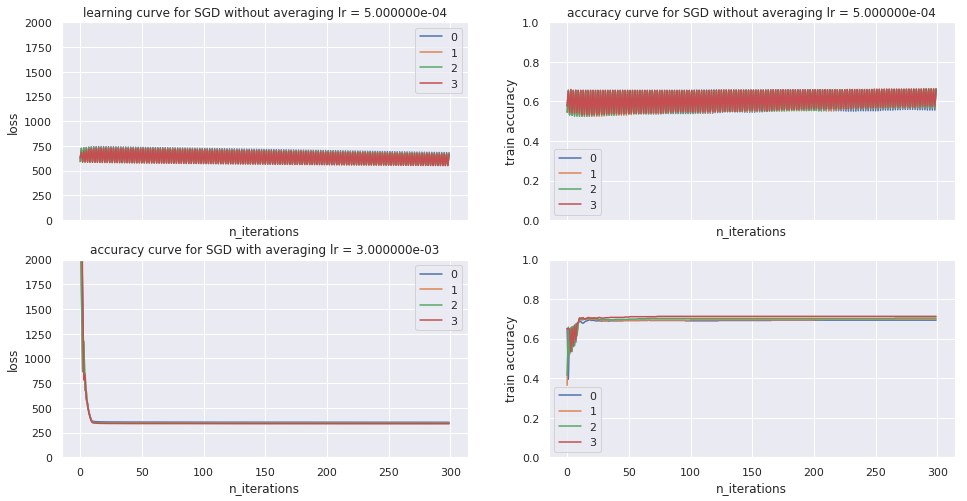

In [7]:
n_seeds = 4
lr = 5e-4
max_iter = 300
batch_size = 1
alpha = 1e-4

fg , axes = plt.subplots(2,2, figsize=(16, 8), sharex='all')
axes.flatten()[0].set_ylabel('loss')
axes.flatten()[0].set_ylim(0,2000)
axes.flatten()[1].set_ylim(0,1)
axes.flatten()[1].set_ylabel('train accuracy')
axes.flatten()[0].set_xlabel('n_iterations')
axes.flatten()[1].set_xlabel('n_iterations')
axes.flatten()[0].set_title('learning curve for SGD without averaging lr = {:2e}'.format(lr))
axes.flatten()[1].set_title('accuracy curve for SGD without averaging lr = {:2e}'.format(lr))
for seed in range(n_seeds):
    logistic_regression = StochasticLogisticRegression(alpha,seed=seed)
    logistic_regression.fit(diabetes_train_x, diabetes_train_y, lr=lr, batch_size=batch_size, max_iter=max_iter)
    axes.flatten()[0].plot(logistic_regression.f_history_, label='no averaging')
    axes.flatten()[1].plot(logistic_regression.acc_history, label='no averaging')
    train_acc =  np.mean(logistic_regression.predict(diabetes_train_x) == diabetes_train_y)
    test_acc = np.mean(logistic_regression.predict(diabetes_test_x) == diabetes_test_y)
    print('Performance for seed {} : train acc = {:4f} | test acc = {:4f} | last loss {:4f}'.format(seed, train_acc, test_acc, logistic_regression.f_history_[-1]))
axes.flatten()[0].legend(range(n_seeds))
axes.flatten()[1].legend(range(n_seeds))


lr = 3e-3
axes.flatten()[2].set_ylabel('loss')
axes.flatten()[2].set_ylim(0,2000)
axes.flatten()[3].set_ylim(0,1)
axes.flatten()[3].set_ylabel('train accuracy')
axes.flatten()[2].set_xlabel('n_iterations')
axes.flatten()[3].set_xlabel('n_iterations')
axes.flatten()[2].set_title('learning curve for SGD with averaging lr = {:2e}'.format(lr))
axes.flatten()[2].set_title('accuracy curve for SGD with averaging lr = {:2e}'.format(lr))
for seed in range(n_seeds):
    logistic_regression = StochasticLogisticRegression(alpha,seed=seed)
    logistic_regression.fit(diabetes_train_x, diabetes_train_y, lr=lr, 
                            batch_size=batch_size, max_iter=max_iter, averaging = True)
    axes.flatten()[2].plot(logistic_regression.f_history_, label='averaging')
    axes.flatten()[3].plot(logistic_regression.acc_history, label='averaging')
    train_acc =  np.mean(logistic_regression.predict(diabetes_train_x) == diabetes_train_y)
    test_acc = np.mean(logistic_regression.predict(diabetes_test_x) == diabetes_test_y)
    print('Performance for seed {} : train acc = {:4f} |'
          'test acc = {:4f} | last loss {:4f}'.format(seed, 
                                        train_acc, 
                                        test_acc, 
                                        logistic_regression.f_history_[-1]))
axes.flatten()[2].legend(range(n_seeds))
axes.flatten()[3].legend(range(n_seeds))

### Observation

We notice an improvement of the results but also the computation is slower because of we benefit less from the vectorization of the computation. 

We will experiment the Mini-batch sgd which allow to take the best of the two methods. 
Averaging does not seems to improve the results. 

## Mini-batch SGD 
We will now experiment the mini batch SGD, with and without averaging and with different acceleration strategies

Performance for seed 0 : train acc = 0.697391 | test acc = 0.677083 | last loss 352.026670
Performance for seed 1 : train acc = 0.704348 | test acc = 0.682292 | last loss 343.139441
Performance for seed 2 : train acc = 0.709565 | test acc = 0.687500 | last loss 341.403210


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


Performance for seed 3 : train acc = 0.718261 | test acc = 0.692708 | last loss 337.725713
Performance for seed 0 : train acc = 0.664348 |test acc = 0.614583 | last loss 451.836053
Performance for seed 1 : train acc = 0.692174 |test acc = 0.687500 | last loss 368.585574
Performance for seed 2 : train acc = 0.697391 |test acc = 0.661458 | last loss 367.439235
Performance for seed 3 : train acc = 0.655652 |test acc = 0.625000 | last loss 496.412921


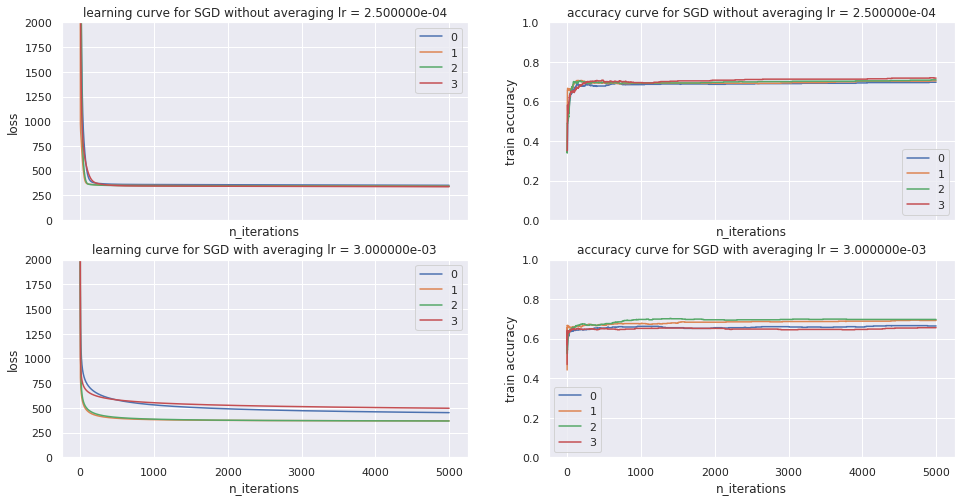

In [8]:
n_seeds = 4
lr = 2.5e-4
max_iter = 5000
batch_size = 50
alpha = 1e-4

fg , axes = plt.subplots(2,2, figsize=(16, 8), sharex='all')
axes.flatten()[0].set_ylabel('loss')
axes.flatten()[0].set_ylim(0,2000)
axes.flatten()[1].set_ylim(0,1)
axes.flatten()[1].set_ylabel('train accuracy')
axes.flatten()[0].set_xlabel('n_iterations')
axes.flatten()[1].set_xlabel('n_iterations')
axes.flatten()[0].set_title('learning curve for SGD without averaging lr = {:2e}'.format(lr))
axes.flatten()[1].set_title('accuracy curve for SGD without averaging lr = {:2e}'.format(lr))
for seed in range(n_seeds):
    logistic_regression = StochasticLogisticRegression(alpha,seed=seed)
    logistic_regression.fit(diabetes_train_x, diabetes_train_y, lr=lr, batch_size=batch_size, max_iter=max_iter)
    axes.flatten()[0].plot(logistic_regression.f_history_, label='no averaging')
    axes.flatten()[1].plot(logistic_regression.acc_history, label='no averaging')
    train_acc =  np.mean(logistic_regression.predict(diabetes_train_x) == diabetes_train_y)
    test_acc = np.mean(logistic_regression.predict(diabetes_test_x) == diabetes_test_y)
    print('Performance for seed {} : train acc = {:4f} | test acc = {:4f} | last loss {:4f}'.format(seed, train_acc, test_acc, logistic_regression.f_history_[-1]))
axes.flatten()[0].legend(range(n_seeds))
axes.flatten()[1].legend(range(n_seeds))


lr = 3e-3
axes.flatten()[2].set_ylabel('loss')
axes.flatten()[2].set_ylim(0,2000)
axes.flatten()[3].set_ylim(0,1)
axes.flatten()[3].set_ylabel('train accuracy')
axes.flatten()[2].set_xlabel('n_iterations')
axes.flatten()[3].set_xlabel('n_iterations')
axes.flatten()[2].set_title('learning curve for SGD with averaging lr = {:2e}'.format(lr))
axes.flatten()[3].set_title('accuracy curve for SGD with averaging lr = {:2e}'.format(lr))
for seed in range(n_seeds):
    logistic_regression = StochasticLogisticRegression(alpha,seed=seed)
    logistic_regression.fit(diabetes_train_x, diabetes_train_y, lr=lr, batch_size=batch_size, max_iter=max_iter, averaging = True)
    axes.flatten()[2].plot(logistic_regression.f_history_, label='averaging')
    axes.flatten()[3].plot(logistic_regression.acc_history, label='averaging')
    train_acc =  np.mean(logistic_regression.predict(diabetes_train_x) == diabetes_train_y)
    test_acc = np.mean(logistic_regression.predict(diabetes_test_x) == diabetes_test_y)
    print('Performance for seed {} : train acc = {:4f} |'
          'test acc = {:4f} | last loss {:4f}'.format(seed, 
                                        train_acc, 
                                        test_acc, 
                                        logistic_regression.f_history_[-1]))
axes.flatten()[2].legend(range(n_seeds))
axes.flatten()[3].legend(range(n_seeds))

### Observation : 
First we notice that the avering allow us to use an higher learning rate. But it doesn't seens to make the convergence faster nor it reaches better results. 

It is also important to notice that the averaging is more dependant to the initialization.

### Learning rate decay $\gamma_t = Ct^{−\nu}$ 


#### Without averaging

Average Performance for nu 0.5: train acc = 0.673043 | test acc = 0.647569
Average Performance for nu 0.75: train acc = 0.689275 | test acc = 0.675347
Average Performance for nu 1: train acc = 0.696232 | test acc = 0.689236


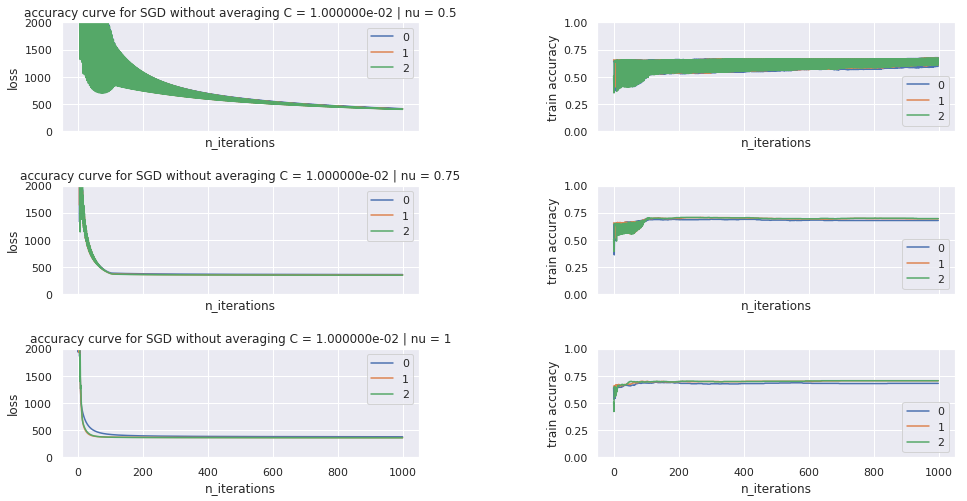

In [9]:
n_seeds = 3
lr = 1e-2
max_iter = 1000
batch_size = 50
alpha = 5e-3
nus = [0.5, 0.75, 1]
fg , axes = plt.subplots(len(nus),2, figsize=(16, 8), sharex='all')
acc = []
for ind,nu in enumerate(nus) :
    lr_method = {'method':'inv_decay','nu':nu} # the decay descriptor dict
    axes[ind][0].set_ylabel('loss')
    axes[ind][0].set_ylim(0,2000)
    axes[ind][1].set_ylim(0,1)
    axes[ind][1].set_ylabel('train accuracy')
    axes[ind][0].set_xlabel('n_iterations')
    axes[ind][1].set_xlabel('n_iterations')
    axes[ind][0].set_title('learning curve for SGD without averaging C = {:2e} | nu = {}'.format(lr, nu))
    axes[ind][0].set_title('accuracy curve for SGD without averaging C = {:2e} | nu = {}'.format(lr, nu))
    mean_train_acc = 0 
    mean_test_acc = 0
    for seed in range(n_seeds):
        logistic_regression = StochasticLogisticRegression(alpha,seed=seed,lr_method=lr_method)
        logistic_regression.fit(diabetes_train_x, diabetes_train_y, lr=lr, batch_size=batch_size, max_iter=max_iter )
        axes[ind][0].plot(logistic_regression.f_history_, label='no averaging')
        axes[ind][1].plot(logistic_regression.acc_history, label='no averaging')
        mean_train_acc +=  np.mean(logistic_regression.predict(diabetes_train_x) == diabetes_train_y)
        mean_test_acc += np.mean(logistic_regression.predict(diabetes_test_x) == diabetes_test_y)
    mean_train_acc /= n_seeds 
    mean_test_acc /= n_seeds   
    acc.append([mean_train_acc,mean_test_acc])
    print('Average Performance for nu {}: train acc = {:4f} | test acc = {:4f}'.format(nu, mean_train_acc, mean_test_acc))
    axes[ind][0].legend(range(n_seeds))
    axes[ind][1].legend(range(n_seeds))

plt.subplots_adjust(hspace=0.5, wspace = 0.5)

#### With averaging


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp


Average Performance for nu 0.3: train acc = 0.689275 | test acc = 0.685764
Average Performance for nu 0.5: train acc = 0.659710 | test acc = 0.651042
Average Performance for nu 1: train acc = 0.673623 | test acc = 0.682292


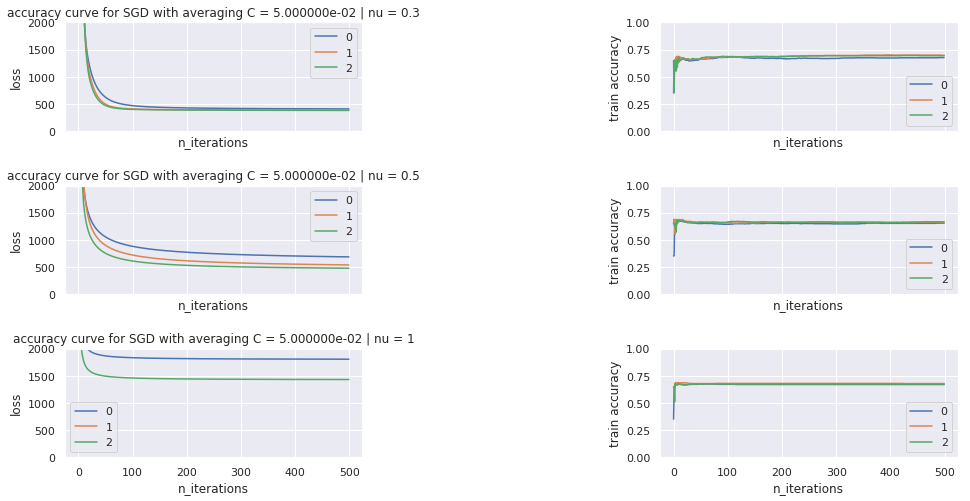

In [10]:
n_seeds = 3
lr = 5e-2
max_iter = 500
batch_size = 50
alpha = 1e-2
nus = [0.3, 0.5,1 ]
fg , axes = plt.subplots(len(nus),2, figsize=(16, 8), sharex='all')
acc = []
for ind,nu in enumerate(nus) :
    lr_method = {'method':'inv_decay','nu':nu} # the decay descriptor dict
    axes[ind][0].set_ylabel('loss')
    axes[ind][0].set_ylim(0,2000)
    axes[ind][1].set_ylim(0,1)
    axes[ind][1].set_ylabel('train accuracy')
    axes[ind][0].set_xlabel('n_iterations')
    axes[ind][1].set_xlabel('n_iterations')
    axes[ind][0].set_title('learning curve for SGD with averaging C = {:2e} | nu = {}'.format(lr, nu))
    axes[ind][0].set_title('accuracy curve for SGD with averaging C = {:2e} | nu = {}'.format(lr, nu))
    mean_train_acc = 0 
    mean_test_acc = 0
    for seed in range(n_seeds):
        logistic_regression = StochasticLogisticRegression(alpha,seed=seed,lr_method=lr_method)
        logistic_regression.fit(diabetes_train_x, diabetes_train_y, lr=lr, batch_size=batch_size, max_iter=max_iter, averaging = True)
        axes[ind][0].plot(logistic_regression.f_history_)
        axes[ind][1].plot(logistic_regression.acc_history)
        mean_train_acc +=  np.mean(logistic_regression.predict(diabetes_train_x) == diabetes_train_y)
        mean_test_acc += np.mean(logistic_regression.predict(diabetes_test_x) == diabetes_test_y)
    mean_train_acc /= n_seeds 
    mean_test_acc /= n_seeds   
    acc.append([mean_train_acc,mean_test_acc])
    print('Average Performance for nu {}: train acc = {:4f} | test acc = {:4f}'.format(nu, mean_train_acc, mean_test_acc))
    axes[ind][0].legend(range(n_seeds))
    axes[ind][1].legend(range(n_seeds))
    
plt.subplots_adjust(hspace=0.5, wspace = 1)

### Observation 
* without averaging : in this case the decay allow us to use higher value of the learning rate and therefore to converge faster and to more optimal value. In this case, the results are better with a stronger decay. 
* with averaging the addition of the decay degrades the result. In fact the averaging already permits convergence with high values of learning rate. So this decay reduce the learning rate value to fast. The results are better with a smaller decay and worse than without decay

The results are better with decay and no averaging than with averaging.
    

## Accelerated Variants

### Momentum 

Average Performance with momentum: train acc = 0.691594 | test acc = 0.673611


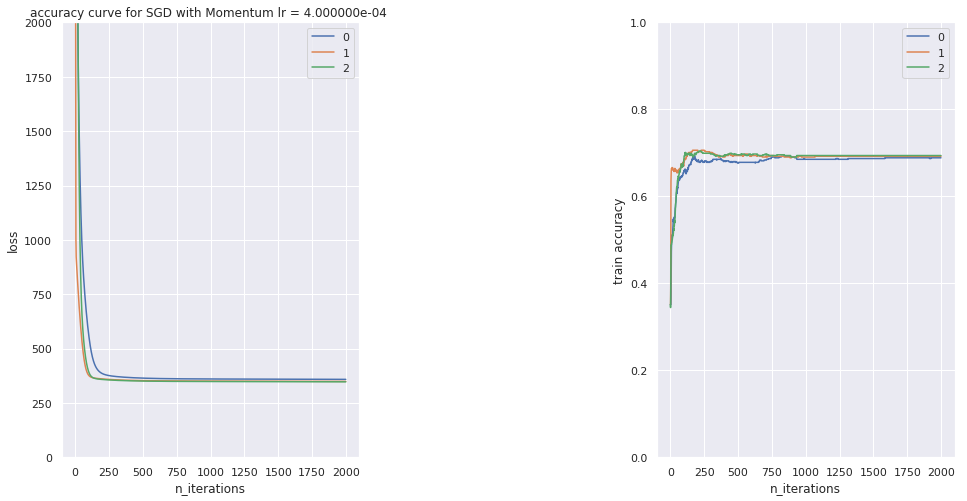

In [11]:
n_seeds = 3
lr = 0.4e-3
max_iter = 2000
batch_size = 50
alpha = 1e-4
fg , axes = plt.subplots(1,2, figsize=(16, 8), sharex='all')
axes[0].set_ylabel('loss')
axes[0].set_ylim(0,2000)
axes[1].set_ylim(0,1)
axes[1].set_ylabel('train accuracy')
axes[0].set_xlabel('n_iterations')
axes[1].set_xlabel('n_iterations')
axes[0].set_title('learning curve for SGD with Momentum lr = {:2e} '.format(lr))
axes[0].set_title('accuracy curve for SGD with Momentum lr = {:2e} '.format(lr))
mean_train_acc = 0 
mean_test_acc = 0
for seed in range(n_seeds):
    logistic_regression = StochasticLogisticRegression(alpha,seed=seed)
    logistic_regression.fit(diabetes_train_x, diabetes_train_y, lr=lr, 
                            batch_size=batch_size, max_iter=max_iter, 
                            acceleration = 'momentum')
    axes[0].plot(logistic_regression.f_history_)
    axes[1].plot(logistic_regression.acc_history)
    mean_train_acc +=  np.mean(logistic_regression.predict(diabetes_train_x) == diabetes_train_y)
    mean_test_acc += np.mean(logistic_regression.predict(diabetes_test_x) == diabetes_test_y)
mean_train_acc /= n_seeds 
mean_test_acc /= n_seeds   
acc.append([mean_train_acc,mean_test_acc])
print('Average Performance with momentum: train acc = {:4f} | test acc = {:4f}'.format( mean_train_acc, mean_test_acc))
axes[0].legend(range(n_seeds))
axes[1].legend(range(n_seeds))
    
plt.subplots_adjust(hspace=0.5, wspace = 1)

### Gradient Averaging

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


Average Performance with gradient averaging: train acc = 0.761739 | test acc = 0.803819


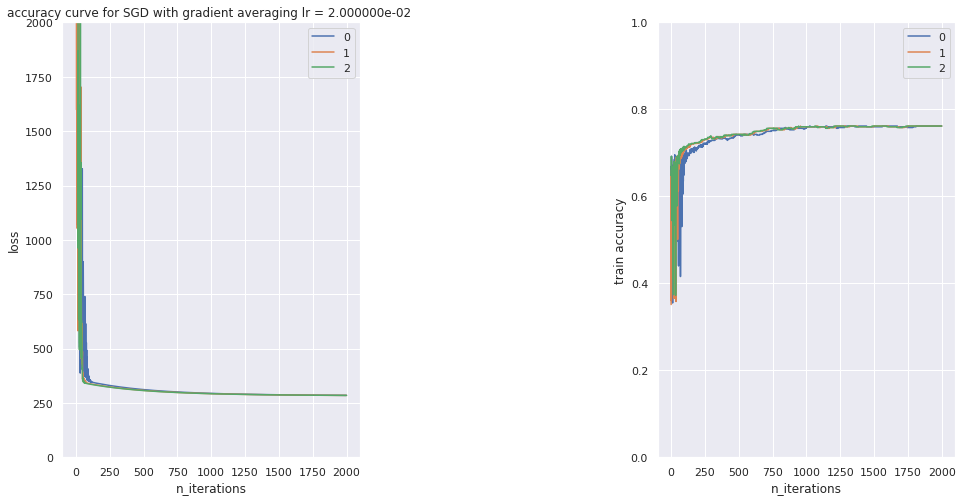

In [12]:
n_seeds = 3
lr = 2e-2
max_iter = 2000
batch_size = 50
alpha = 1e-4
fg , axes = plt.subplots(1,2, figsize=(16, 8), sharex='all')
axes[0].set_ylabel('loss')
axes[0].set_ylim(0,2000)
axes[1].set_ylim(0,1)
axes[1].set_ylabel('train accuracy')
axes[0].set_xlabel('n_iterations')
axes[1].set_xlabel('n_iterations')
axes[0].set_title('learning curve for SGD with gradient averaging lr = {:2e} '.format(lr))
axes[0].set_title('accuracy curve for SGD with gradient averaging lr = {:2e} '.format(lr))
mean_train_acc = 0 
mean_test_acc = 0
for seed in range(n_seeds):
    logistic_regression = StochasticLogisticRegression(alpha,seed=seed)
    logistic_regression.fit(diabetes_train_x, diabetes_train_y, lr=lr, 
                            batch_size=batch_size, max_iter=max_iter, 
                            acceleration = 'gradient_averaging')
    axes[0].plot(logistic_regression.f_history_)
    axes[1].plot(logistic_regression.acc_history)
    mean_train_acc +=  np.mean(logistic_regression.predict(diabetes_train_x) == diabetes_train_y)
    mean_test_acc += np.mean(logistic_regression.predict(diabetes_test_x) == diabetes_test_y)
mean_train_acc /= n_seeds 
mean_test_acc /= n_seeds   
acc.append([mean_train_acc,mean_test_acc])
print('Average Performance with gradient averaging: train acc = {:4f} | test acc = {:4f}'.format( mean_train_acc, mean_test_acc))
axes[0].legend(range(n_seeds))
axes[1].legend(range(n_seeds))
    
plt.subplots_adjust(hspace=0.5, wspace = 1)

### Adagrad 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp


Average Performance with adagrad: train acc = 0.675942 | test acc = 0.664931


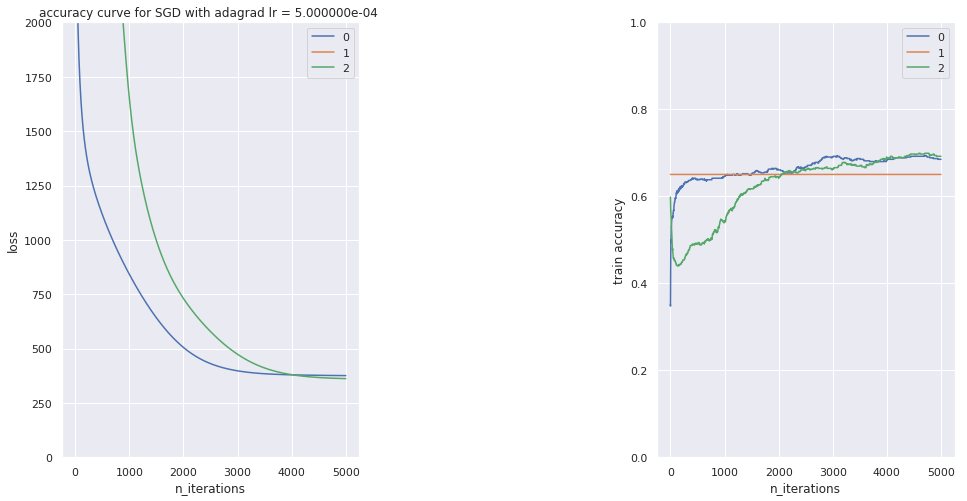

In [21]:
n_seeds = 3
lr = 5e-4
max_iter = 5000
batch_size = 50
alpha = 1e-4
fg , axes = plt.subplots(1,2, figsize=(16, 8), sharex='all')
axes[0].set_ylabel('loss')
axes[0].set_ylim(0,2000)
axes[1].set_ylim(0,1)
axes[1].set_ylabel('train accuracy')
axes[0].set_xlabel('n_iterations')
axes[1].set_xlabel('n_iterations')
axes[0].set_title('learning curve for SGD with adagrad lr = {:2e} '.format(lr))
axes[0].set_title('accuracy curve for SGD with adagrad lr = {:2e} '.format(lr))
mean_train_acc = 0 
mean_test_acc = 0
for seed in range(n_seeds):
    logistic_regression = StochasticLogisticRegression(alpha,seed=seed)
    logistic_regression.fit(diabetes_train_x, diabetes_train_y, lr=lr, 
                            batch_size=batch_size, max_iter=max_iter, 
                            acceleration = 'adagrad')
    axes[0].plot(logistic_regression.f_history_)
    axes[1].plot(logistic_regression.acc_history)
    mean_train_acc +=  np.mean(logistic_regression.predict(diabetes_train_x) == diabetes_train_y)
    mean_test_acc += np.mean(logistic_regression.predict(diabetes_test_x) == diabetes_test_y)
mean_train_acc /= n_seeds 
mean_test_acc /= n_seeds   
acc.append([mean_train_acc,mean_test_acc])
print('Average Performance with adagrad: train acc = {:4f} | test acc = {:4f}'.format( mean_train_acc, mean_test_acc))
axes[0].legend(range(n_seeds))
axes[1].legend(range(n_seeds))
    
plt.subplots_adjust(hspace=0.5, wspace = 1)

### obeservation 
* The momemtum acceleration or adagrad does not yields results as good as the gradient averaging
* The stability of the gradient averaging allows to use very high learning rate and make possible to reach results comaprable to sklearn value.

### Impact of the batch size
We will be using the set up which gave us the best results ie gradient averaging. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp


Average Performance for batch_size 5: train acc = 0.765217 | test acc = 0.807292
Average Performance for batch_size 20: train acc = 0.766957 | test acc = 0.802083
Average Performance for batch_size 30: train acc = 0.765217 | test acc = 0.807292
Average Performance for batch_size 50: train acc = 0.761739 | test acc = 0.803819
Average Performance for batch_size 70: train acc = 0.760580 | test acc = 0.812500


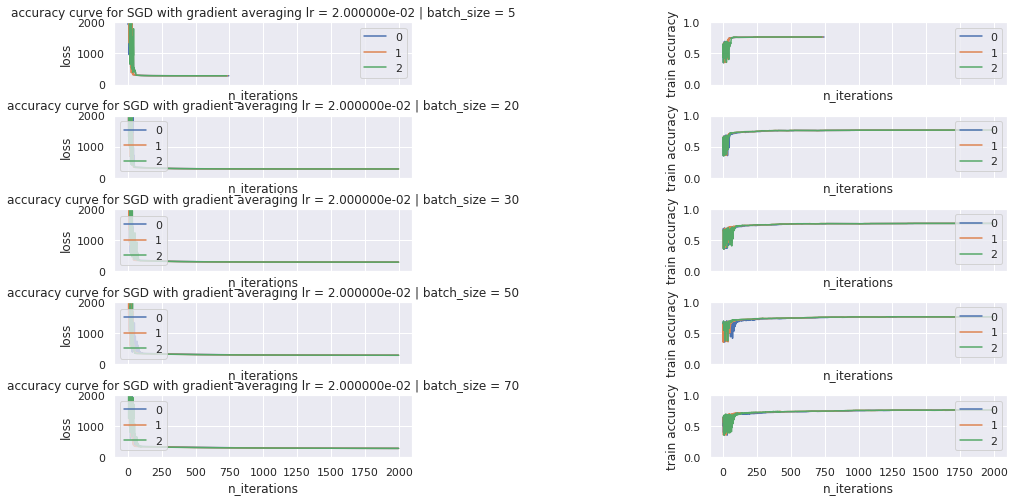

In [18]:
n_seeds = 3
lr = 2e-2
max_iter = 2000
alpha = 1e-4
bs = [5, 20, 30, 50, 70 ]
fg , axes = plt.subplots(len(bs),2, figsize=(16, 8), sharex='all')
acc = []
for ind,batch_size in enumerate(bs) :
 # the decay descriptor dict
    axes[ind][0].set_ylabel('loss')
    axes[ind][0].set_ylim(0,2000)
    axes[ind][1].set_ylim(0,1)
    axes[ind][1].set_ylabel('train accuracy')
    axes[ind][0].set_xlabel('n_iterations')
    axes[ind][1].set_xlabel('n_iterations')
    axes[ind][0].set_title('learning curve for SGD with gradient averaging lr = {:2e} | batch_size = {}'.format(lr, batch_size))
    axes[ind][0].set_title('accuracy curve for SGD with gradient averaging lr = {:2e} | batch_size = {}'.format(lr, batch_size))
    mean_train_acc = 0 
    mean_test_acc = 0
    for seed in range(n_seeds):
        logistic_regression = StochasticLogisticRegression(alpha,seed=seed)
        logistic_regression.fit(diabetes_train_x, diabetes_train_y, lr=lr, 
                            batch_size=batch_size, max_iter=max_iter, 
                            acceleration = 'gradient_averaging')
        axes[ind][0].plot(logistic_regression.f_history_)
        axes[ind][1].plot(logistic_regression.acc_history)
        mean_train_acc +=  np.mean(logistic_regression.predict(diabetes_train_x) == diabetes_train_y)
        mean_test_acc += np.mean(logistic_regression.predict(diabetes_test_x) == diabetes_test_y)
    mean_train_acc /= n_seeds 
    mean_test_acc /= n_seeds   
    acc.append([mean_train_acc,mean_test_acc])
    print('Average Performance for batch_size {}: train acc = {:4f} | test acc = {:4f}'.format(batch_size, mean_train_acc, mean_test_acc))
    axes[ind][0].legend(range(n_seeds))
    axes[ind][1].legend(range(n_seeds))
    
plt.subplots_adjust(hspace=0.5, wspace = 1)

### observation 
We observe that a batch size too small cause a slower computation time and lower performance because the estimate of the gradient is not as good. However a batch size too big cause less iteration per epoch and therefore less update of the coefficient for a fixed number of epochs. The variation in score are not very sensitive in a certain range of batch size.